In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
import tensorflow as tf
import numpy as np
from nltk.stem import PorterStemmer

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
data = pd.read_csv('gdrive/My Drive/fake/w2v/newdata.csv')

In [4]:
data.shape

(6420, 3)

In [5]:
data.head(10)

,id,tweet,label
0,1,the cdc currently reports deaths in general th...,1
1,2,states reported deaths a small rise from last ...,1
2,3,politically correct woman almost uses pandemic...,0
3,4,indiafightscorona we have covid testing labora...,1
4,5,populous states can generate large case counts...,1
5,6,covid act now found on average each person in ...,1
6,7,if you tested positive for covid and have no s...,1
7,8,obama calls trump’s coronavirus response a cha...,0
8,9,clearly the obama administration did not leave...,0
9,10,retraction—hydroxychloroquine or chloroquine w...,0


In [6]:
#Stemming
ps = PorterStemmer()
data['tweet'] = data['tweet'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))

In [7]:
corpus = []
for i in range(0, len(data["tweet"])):
  corpus.append(data["tweet"][i])

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data['label'],test_size = 0.1, random_state = 98)


In [10]:
pip install gensim

In [11]:
from gensim.models import Word2Vec

Embedding_dimensions = 200
type(X_train)
#Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [12]:
Word2vec_train_data


[['“the',
  'bad',
  'news',
  'is',
  'the',
  'covid',
  'case',
  'are',
  'still',
  'rise',
  'the',
  'good',
  'news',
  'is',
  'that',
  'a',
  'reduct',
  'depend',
  'on',
  'collect',
  'effort',
  'amp',
  'adher',
  'to',
  'recommend',
  'measur',
  'we',
  'need',
  'more',
  'voic',
  'other',
  'than',
  'ncdc',
  'to',
  'send',
  'the',
  'right',
  'messag',
  'to',
  'nigerians”',
  'dg',
  'ncdc',
  'on'],
 ['gilead',
  'will',
  'studi',
  'remdesivir',
  'in',
  'pediatr',
  'covid',
  'patient'],
 ['here',
  's',
  'our',
  'daili',
  'updat',
  'for',
  'we',
  'have',
  'track',
  'cumul',
  'peopl',
  'test',
  'here',
  'in',
  'the',
  'us',
  'by',
  'talli',
  'individu',
  'state',
  'report',
  'that',
  's',
  'up',
  'from',
  'yesterday',
  'note',
  'we',
  'cannot',
  'captur',
  'all',
  'neg',
  'test',
  'becaus',
  'not',
  'all',
  'state',
  'report',
  'them'],
 ['a',
  'small',
  'citi',
  'on',
  'the',
  'countrysid',
  'of',
  'brazil'

In [13]:
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.vocab))

Vocabulary Length: 2433


In [14]:
input_length = 200
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(corpus)

vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 9425


In [16]:
 len(tokenizer.word_index)

9424

In [17]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (5778, 200)
X_test.shape : (642, 200)


In [18]:
from gensim.models import KeyedVectors

In [19]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))
for word, token in tokenizer.word_index.items():
  if word2vec_model.wv.__contains__(word):
      embedding_matrix[token] = word2vec_model.wv.__getitem__(word)
print("Embedding Matrix Shape:", embedding_matrix.shape)   

Embedding Matrix Shape: (9425, 200)


In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding , SimpleRNN


In [21]:
embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)
modeld = Sequential()
modeld.add(embedding_layer)
modeld.add(LSTM(128,return_sequences=True))
modeld.add(LSTM(64,return_sequences=True))
modeld.add(LSTM(32))
modeld.add(Dense(1, activation='sigmoid'))
modeld.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
modeld.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          1885000   
                                                                 
 lstm (LSTM)                 (None, 200, 128)          168448    
                                                                 
 lstm_1 (LSTM)               (None, 200, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,115,305
Trainable params: 230,305
Non-trainable params: 1,885,000
_________________________________________________________________


In [22]:
d = modeld.fit(X_train, y_train, batch_size=64, epochs=10,callbacks=callbacks,verbose=1, validation_split=0.2)


NameError: ignored

In [ ]:
pred=(modeld.predict(X_test) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test,pred)
acc

0.8348909657320872

In [ ]:
from sklearn.metrics import confusion_matrix
con=confusion_matrix(y_test,pred)
con

array([[146,  18],
       [ 35, 122]])

In [ ]:
d.history

{'accuracy': [0.7325271368026733,
  0.791555643081665,
  0.792170524597168,
  0.8036482930183411,
  0.8251690864562988,
  0.831932783126831,
  0.8327525854110718,
  0.8352121114730835,
  0.8366468548774719,
  0.8391063809394836],
 'loss': [0.5149373412132263,
  0.4483657479286194,
  0.4369737505912781,
  0.41808760166168213,
  0.38157644867897034,
  0.37440225481987,
  0.36959344148635864,
  0.36081457138061523,
  0.3630391061306,
  0.356708824634552],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
 'val_accuracy': [0.7729508280754089,
  0.7188524603843689,
  0.841803252696991,
  0.8139344453811646,
  0.8336065411567688,
  0.7909836173057556,
  0.8491803407669067,
  0.8295081853866577,
  0.8008196949958801,
  0.8491803407669067],
 'val_loss': [0.465751975774765,
  0.5530080199241638,
  0.40147438645362854,
  0.3913581669330597,
  0.3600570559501648,
  0.4426572620868683,
  0.3388770818710327,
  0.36022430658340454,
  0.3893459141254425,
  0.3471905887126

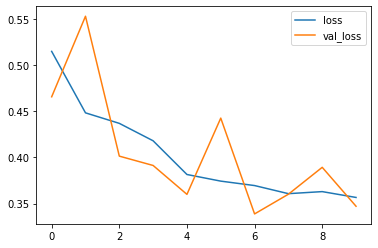

In [ ]:
# Evaluating the model
# plotting the loss and validation loss of the model
plt.plot(d.history['loss'], label='loss')
plt.plot(d.history['val_loss'], label = 'val_loss')
plt.legend()

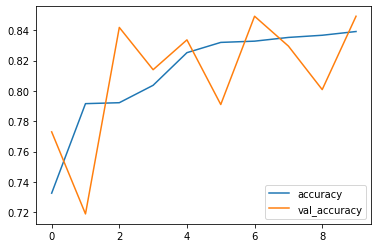

In [ ]:
# plotting the accuracy and validation accuracy of the model
plt.plot(d.history['accuracy'], label= 'accuracy')
plt.plot(d.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
from sklearn.metrics import classification_report

print(print(classification_report(y_test,pred,target_names=['real','fake'])))

              precision    recall  f1-score   support

        real       0.81      0.89      0.85       164
        fake       0.87      0.78      0.82       157

    accuracy                           0.83       321
   macro avg       0.84      0.83      0.83       321
weighted avg       0.84      0.83      0.83       321

None


test A

In [23]:
embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)
modela = Sequential()
modela.add(embedding_layer)
modela.add(Bidirectional(LSTM(256)))
modela.add(Dense(1, activation='sigmoid'))
modela.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

In [24]:
modela.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          1885000   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              935936    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,821,449
Trainable params: 936,449
Non-trainable params: 1,885,000
_________________________________________________________________


In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [26]:
a = modela.fit(X_train, y_train, batch_size=128, epochs=10,verbose=1, validation_split=0.2,callbacks=callbacks)


Epoch 1/10
37/37 [==============================] - 117s 3s/step - loss: 0.5069 - accuracy: 0.7460 - val_loss: 0.4374 - val_accuracy: 0.7846 - lr: 0.0010
Epoch 2/10
37/37 [==============================] - 110s 3s/step - loss: 0.4460 - accuracy: 0.7858 - val_loss: 0.4068 - val_accuracy: 0.8097 - lr: 0.0010
Epoch 3/10
37/37 [==============================] - 111s 3s/step - loss: 0.4331 - accuracy: 0.7908 - val_loss: 0.4341 - val_accuracy: 0.7950 - lr: 0.0010
Epoch 4/10
37/37 [==============================] - 111s 3s/step - loss: 0.4140 - accuracy: 0.8087 - val_loss: 0.3920 - val_accuracy: 0.8270 - lr: 0.0010
Epoch 5/10
37/37 [==============================] - 112s 3s/step - loss: 0.3906 - accuracy: 0.8219 - val_loss: 0.3782 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 6/10
37/37 [==============================] - 111s 3s/step - loss: 0.3938 - accuracy: 0.8252 - val_loss: 0.3537 - val_accuracy: 0.8555 - lr: 0.0010
Epoch 7/10
37/37 [==============================] - 111s 3s/step - loss: 0.3

In [27]:
pred=(modela.predict(X_test) > 0.5).astype("int32")

In [28]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test,pred)
acc

0.822429906542056

In [29]:
from sklearn.metrics import confusion_matrix
con=confusion_matrix(y_test,pred)
con

array([[261,  44],
       [ 70, 267]])

In [30]:
a.history

{'accuracy': [0.745997428894043,
  0.7858070135116577,
  0.7907832264900208,
  0.8087407946586609,
  0.8219385743141174,
  0.8251839280128479,
  0.8340545296669006,
  0.843141496181488,
  0.8286455869674683,
  0.8310255408287048],
 'loss': [0.5069053173065186,
  0.44597291946411133,
  0.4331168830394745,
  0.4139924943447113,
  0.39064204692840576,
  0.39381203055381775,
  0.3715571463108063,
  0.3619828522205353,
  0.3722742199897766,
  0.3665373623371124],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
 'val_accuracy': [0.7846021056175232,
  0.8096885681152344,
  0.7949826717376709,
  0.8269895911216736,
  0.8365051746368408,
  0.8555363416671753,
  0.8365051746368408,
  0.8287197351455688,
  0.8399654030799866,
  0.8512110710144043],
 'val_loss': [0.4373846650123596,
  0.40679943561553955,
  0.43412718176841736,
  0.3919597864151001,
  0.37816739082336426,
  0.35367128252983093,
  0.36424827575683594,
  0.38098132610321045,
  0.36116042733192444,
  0.

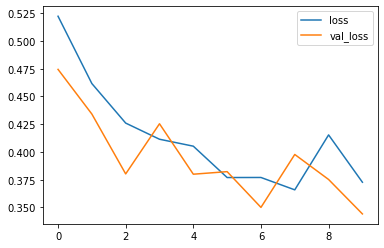

In [ ]:
# Evaluating the model
# plotting the loss and validation loss of the model
plt.plot(a.history['loss'], label='loss')
plt.plot(a.history['val_loss'], label = 'val_loss')
plt.legend()

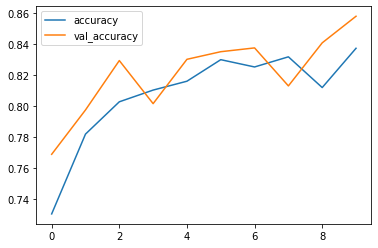

In [ ]:
# plotting the accuracy and validation accuracy of the model
plt.plot(a.history['accuracy'], label= 'accuracy')
plt.plot(a.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
from sklearn.metrics import classification_report
print(print(classification_report(y_test,pred,target_names=['real','fake'])))

              precision    recall  f1-score   support

        real       0.81      0.88      0.84       164
        fake       0.86      0.79      0.82       157

    accuracy                           0.83       321
   macro avg       0.84      0.83      0.83       321
weighted avg       0.84      0.83      0.83       321

None
